In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r"/content/drive/MyDrive/dataset/updated_data01.csv",
                 index_col='Date',
                 parse_dates=True,
                 dayfirst=True)

# Preprocess data
df = df.sort_index(ascending=True)
df = df.reset_index().drop_duplicates(subset='Date').set_index('Date')
df.drop_duplicates(inplace=True)

# Drop rows with missing values
df.dropna(subset=['Quantity', 'Nasdaq_100_Price', 'Gold_Price', 'Crude_oil_Price', 'S&P_500_Price'], inplace=True)

# Scale data
scaler = StandardScaler()
df['Quantity_scaled'] = scaler.fit_transform(df[['Quantity']])
df['Nasdaq_100_Price_scaled'] = scaler.fit_transform(df[['Nasdaq_100_Price']])
df['Gold_Price_scaled'] = scaler.fit_transform(df[['Gold_Price']])
df['Crude_oil_Price_scaled'] = scaler.fit_transform(df[['Crude_oil_Price']])
df['S&P_500_Price_scaled'] = scaler.fit_transform(df[['S&P_500_Price']])

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Check Stationarity
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())  # Print the result
    if result[1] <= 0.05:
        print("Reject the null hypothesis - Time series is stationary")
    else:
        print("Fail to reject the null hypothesis - Time series is non-stationary")

adf_test(df['Quantity'], 'Quantity')

Augmented Dickey-Fuller Test: Quantity
ADF Test Statistic     -7.800935e+00
p-value                 7.496724e-12
# Lags Used             0.000000e+00
# Observations Used     7.800000e+01
Critical Value (1%)    -3.517114e+00
Critical Value (5%)    -2.899375e+00
Critical Value (10%)   -2.586955e+00
Reject the null hypothesis - Time series is stationary


In [ ]:
df['Quantity_diff'] = df['Quantity'].diff().dropna()
# Gradient Boosting Model
features = ['Nasdaq_100_Price_scaled', 'Gold_Price_scaled', 'Crude_oil_Price_scaled', 'S&P_500_Price_scaled']
target = 'Quantity'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
gbr.fit(X_train, y_train)

gbr_predictions = gbr.predict(X_test)
test = test.assign(GBR_Prediction=gbr_predictions)


In [ ]:
def arima_model(train_series, target):
    model = ARIMA(train_series, order=(5, 1, 0))
    model_fit = model.fit()
    return model_fit

train_arima = train[target]
arima_model_fit = arima_model(train_arima.values, target)
arima_predictions = arima_model_fit.predict(start=len(train), end=len(df) - 1)
test = test.assign(ARIMA_Prediction=arima_predictions)


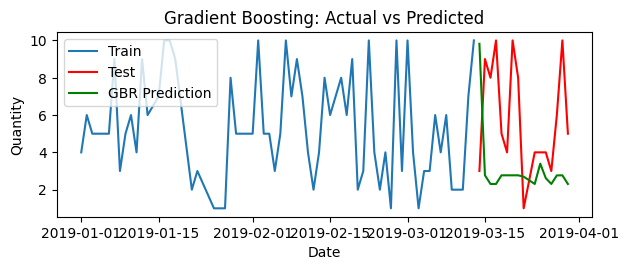

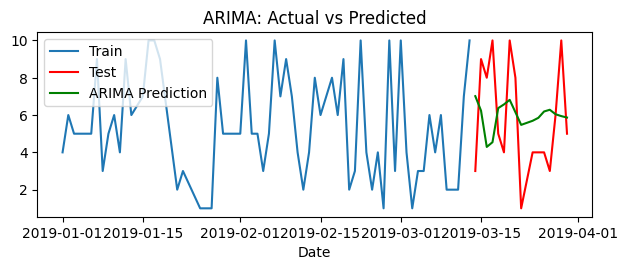

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(test.index, test['Quantity'], label='Test', color='red')
plt.plot(test.index, test['GBR_Prediction'], label='GBR Prediction', color='green')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.tight_layout()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(test.index, test['Quantity'], label='Test', color='red')
plt.plot(test.index, test['ARIMA_Prediction'], label='ARIMA Prediction', color='green')
plt.title('ARIMA: Actual vs Predicted')
plt.xlabel('Date')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the data
data = pd.read_csv('/content/drive/MyDrive/dataset/updated_data01.csv')

# Only keep the 'Quantity' column for ARIMA
y = data['Quantity']

# Split data into training and test sets
train_size = int(len(y) * 0.8)

train, test = y.iloc[:train_size], y.iloc[train_size:]
# Fit the ARIMA model
arima_order = (5, 1, 0)  # You can adjust these parameters (p, d, q)
arima_model = ARIMA(train, order=arima_order)
arima_result = arima_model.fit()

# Forecast
start_index = len(train)
end_index = len(train) + len(test) - 1
arima_forecast = arima_result.predict(start=start_index, end=end_index, typ='levels')

# Create a DataFrame to store true values and predictions
forecast_df = test.to_frame().copy()
forecast_df['ARIMA_Prediction'] = arima_forecast.values

# Evaluate performance
def evaluate_performance(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)

    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print("ARIMA Model Performance:")
evaluate_performance(forecast_df['Quantity'], forecast_df['ARIMA_Prediction'])

MSE: 8.5945
RMSE: 2.9316
MAE: 2.5141
ARIMA Model Performance:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
